In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [4]:
import json

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from src.settings import TrainerSetting

from src.utils.utils import get_surface_dict, get_valid_voxels, get_valid_result
from src.utils.meta import read_result_meta

from src.utils.plot import (
    config_plotting,
    figsize_dict,
    plot_simple_flatmap,
    plot_cluster_on_flatmap,
    create_discrete_cmap
)
from src.utils.weight import process_primal_weight

In [5]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

subject_id = "TYE"
result_meta_dir = ".temp/result_meta/bling"

result_metric = "r2"

alpha = 0.05

plotting_context='paper'

analysis_name = "semantic_cluster"

In [6]:
subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

trainer_en_file = (
    f".temp/config/bling/train/stepwise/{subject_id.lower()}_en-save_primal.json"
)
trainer_zh_file = (
    f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh-save_primal.json"
)

feature_file_en = f".temp/config/bling/feature/{subject_id}/fasttext_stepwise_en.json"
feature_file_zh = f".temp/config/bling/feature/{subject_id}/fasttext_stepwise_zh.json"

trainer_en_ts_file = (
    f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
)

trainer_zh_ts_file = (
    f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
)

feature_file_en_ts = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
feature_file_zh_ts = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

cluster_centroids_file = f".temp/misc/semantic_cluster/cluster_centroids_bling.npy"

image_dir = os.path.join(".temp/image/", analysis_name, subject_id)

In [7]:
surface_dict = get_surface_dict(subject_id)

config_plotting(context=plotting_context)

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    

In [8]:
# loading semantic vem

en_meta_df = read_result_meta(
    result_meta_dir,
    trainer_setting_path=trainer_en_file,
    subject_setting_path=subject_file_en,
    feature_setting_path=feature_file_en,
)
zh_meta_df = read_result_meta(
    result_meta_dir,
    trainer_setting_path=trainer_zh_file,
    subject_setting_path=subject_file_zh,
    feature_setting_path=feature_file_zh,
)

# load trainer json file to TrainerSetting
with open(trainer_en_file, "r") as f:
    trainer_setting_en = TrainerSetting(**json.load(f))
    
en_config = en_meta_df.iloc[0].to_dict()
zh_config = zh_meta_df.iloc[0].to_dict()


en_stat = en_config["stats_path"]
en_stat = np.load(en_stat)

zh_stat = zh_config["stats_path"]
zh_stat = np.load(zh_stat)

valid_en_voxel_mask, valid_en_voxel_idx = get_valid_voxels(en_stat, metric=result_metric, alpha=alpha)
valid_zh_voxel_mask, valid_zh_voxel_idx = get_valid_voxels(zh_stat, metric=result_metric, alpha=alpha)

valid_voxel_mask = valid_en_voxel_mask & valid_zh_voxel_mask
valid_voxel_idx = np.intersect1d(valid_en_voxel_idx, valid_zh_voxel_idx)

en_joint_pred_acc = en_stat[f"test_joint_{result_metric}_score_mask"]
zh_joint_pred_acc = zh_stat[f"test_joint_{result_metric}_score_mask"]

# get sqrt
if result_metric == 'r2':
    en_joint_pred_acc = np.sqrt(en_joint_pred_acc)
    zh_joint_pred_acc = np.sqrt(zh_joint_pred_acc)

/tmp/ipykernel_4001654/903247518.py:41: RuntimeWarning: invalid value encountered in sqrt
  en_joint_pred_acc = np.sqrt(en_joint_pred_acc)
/tmp/ipykernel_4001654/903247518.py:42: RuntimeWarning: invalid value encountered in sqrt
  zh_joint_pred_acc = np.sqrt(zh_joint_pred_acc)


In [9]:
# loading timescale vem
en_meta_df = read_result_meta(
    result_meta_dir,
    trainer_setting_path=trainer_en_ts_file,
    subject_setting_path=subject_file_en,
    feature_setting_path=feature_file_en_ts,)

zh_meta_df = read_result_meta(
    result_meta_dir,
    trainer_setting_path=trainer_zh_ts_file,
    subject_setting_path=subject_file_zh,
    feature_setting_path=feature_file_zh_ts,
)

# load trainer json file to TrainerSetting
with open(trainer_en_file, "r") as f:
    trainer_setting_en = TrainerSetting(**json.load(f))
en_ts_config = en_meta_df.iloc[0].to_dict()
zh_ts_config = zh_meta_df.iloc[0].to_dict()
    
en_ts_stat = en_ts_config["stats_path"]
en_ts_stat = np.load(en_ts_stat)

zh_ts_stat = zh_ts_config["stats_path"]
zh_ts_stat = np.load(zh_ts_stat)

valid_en_ts_voxel_mask, valid_en_ts_voxel_idx = get_valid_voxels(en_ts_stat, metric=result_metric, alpha=alpha)
valid_zh_ts_voxel_mask, valid_zh_ts_voxel_idx = get_valid_voxels(zh_ts_stat, metric=result_metric, alpha=alpha)

valid_ts_voxel_mask = valid_en_ts_voxel_mask & valid_zh_ts_voxel_mask
valid_ts_voxel_idx = np.intersect1d(valid_en_ts_voxel_idx, valid_zh_ts_voxel_idx)

en_timescale = en_ts_stat[f"test_{result_metric}_selectivity_mask"]
zh_timescale = zh_ts_stat[f"test_{result_metric}_selectivity_mask"]

In [10]:
# loading fasttext embeddings

en_fasttext = ".temp/misc/word_list/en_fasttext_embeddings.npy"
zh_fasttext = ".temp/misc/word_list/zh_fasttext_embeddings.npy"

en_fasttext = np.load(en_fasttext, allow_pickle=True).tolist()
zh_fasttext = np.load(zh_fasttext, allow_pickle=True).tolist()

en_words = list(en_fasttext.keys())
zh_words = list(zh_fasttext.keys())

# get word from en_words and zh_words
en_words = np.array(en_words)
zh_words = np.array(zh_words)

# now get all value from en_fasttext dictionary and project that to pca
en_fasttext_values = np.array(list(en_fasttext.values()))
zh_fasttext_values = np.array(list(zh_fasttext.values()))


# Plot prediction accuracy

In [11]:
# get vmin and vmax for both en and zh, removing nan
vmin = min(np.nanmin(en_joint_pred_acc), np.nanmin(zh_joint_pred_acc))
vmax = max(np.nanmax(en_joint_pred_acc), np.nanmax(zh_joint_pred_acc))

Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


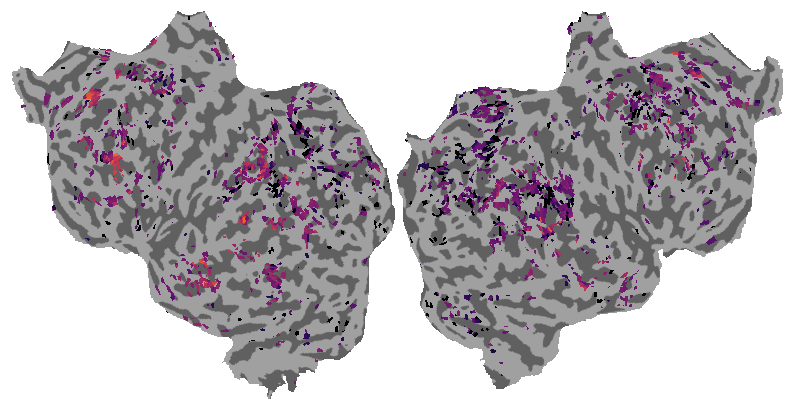

In [12]:
fig, ax = plt.subplots(1, 1, figsize=figsize_dict['full'])

en_data = en_joint_pred_acc
en_data[~valid_en_voxel_mask] = np.nan

plot_simple_flatmap(
    en_data,
    surface_dict,
    vmin=vmin,
    vmax=vmax,
    curvature=True,
    cmap="inferno",
    ax=ax
)

# saving fig
png_fn = os.path.join(image_dir, f"en_pred_acc.png")
plt.savefig(png_fn, bbox_inches='tight', dpi=300)

plt.show()

Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


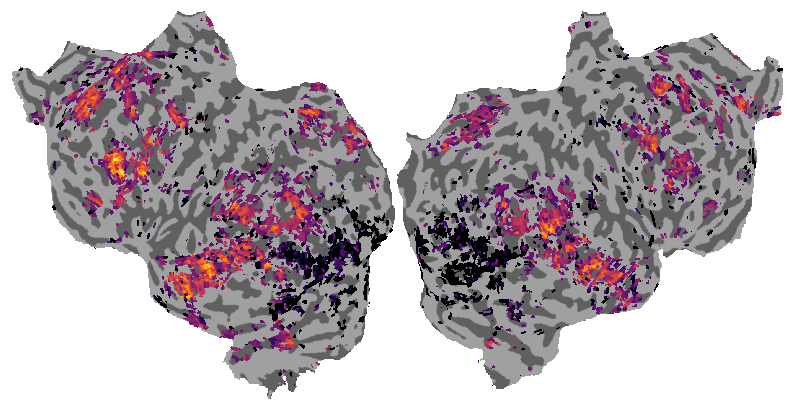

In [13]:
fig, ax = plt.subplots(1, 1, figsize=figsize_dict['full'])

zh_data = zh_joint_pred_acc
zh_data[~valid_zh_voxel_mask] = np.nan

plot_simple_flatmap(
    zh_data,
    surface_dict,
    vmin=vmin,
    vmax=vmax,
    curvature=True,
    cmap="inferno",
    ax=ax
)

png_fn = os.path.join(image_dir, f"zh_pred_acc.png")

plt.savefig(png_fn, bbox_inches='tight', dpi=300)

plt.show()

# Cluster analysis

In [14]:
centroids = np.load(cluster_centroids_file)

In [15]:
en_primal_weight = en_config["primal_weights_path"]
en_primal_weight = np.squeeze(np.load(en_primal_weight)["primal_weights"])

zh_primal_weight = zh_config["primal_weights_path"]
zh_primal_weight = np.squeeze(np.load(zh_primal_weight)["primal_weights"])

en_primal_weight = process_primal_weight(en_primal_weight, en_joint_pred_acc, normalize=True)
zh_primal_weight = process_primal_weight(zh_primal_weight, zh_joint_pred_acc, normalize=True)

en_primal_weight = en_primal_weight[valid_voxel_idx]
zh_primal_weight = zh_primal_weight[valid_voxel_idx]

In [16]:
def cluster(x, centroids):
    return np.argmin(np.linalg.norm(x - centroids, axis=1))

In [17]:
en_cluster_idx = np.array([cluster(x, centroids) for x in en_primal_weight])
zh_cluster_idx = np.array([cluster(x, centroids) for x in zh_primal_weight])

In [18]:
en_cluster_voxels = np.full(en_joint_pred_acc.shape, np.nan)
en_cluster_voxels[valid_voxel_idx] = en_cluster_idx

zh_cluster_voxels = np.full(zh_joint_pred_acc.shape, np.nan)
zh_cluster_voxels[valid_voxel_idx] = zh_cluster_idx

Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


<Axes: >

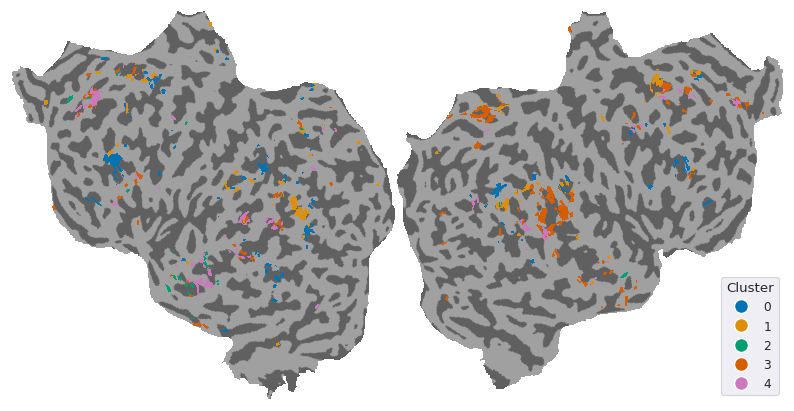

In [19]:
plot_cluster_on_flatmap(
    en_cluster_voxels,
    surface_dict,)

Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


<Axes: >

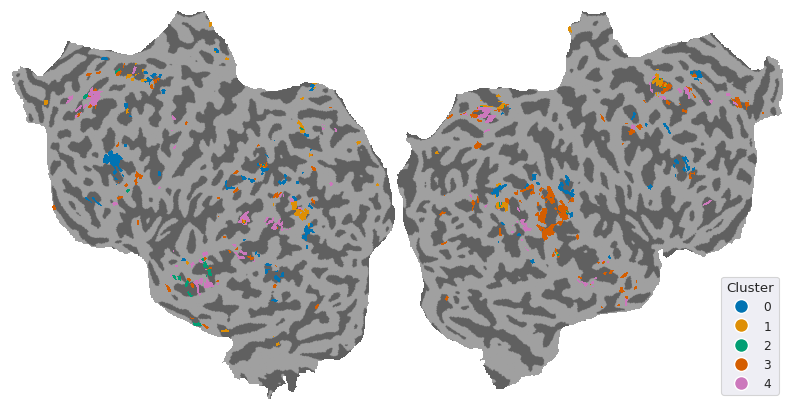

In [20]:
plot_cluster_on_flatmap(
    zh_cluster_voxels,
    surface_dict,)

In [21]:
def plot_histogram_for_each_cluster(
    timescale: np.ndarray,
    cluster: np.ndarray,
    cmap: ListedColormap,
    y_label: str,
    title: bool = True,
    axs=None,
):
    n_clusters = int(np.nanmax(cluster)) + 1

    if axs is None:
        fig, axs = plt.subplots(
            n_clusters, 1, figsize=(10, 10), sharex=True, sharey=True
        )

    for i in range(n_clusters):
        cluster_idx = np.where(cluster == i)[0]
        cluster_timescale = timescale[cluster_idx]
        # drop nan
        cluster_timescale = cluster_timescale[~np.isnan(cluster_timescale)]

        sns.kdeplot(cluster_timescale, ax=axs[i], fill=True, color=cmap(i))
        if title:
            axs[i].set_title(f"Cluster {i}")
        axs[i].set_xlim(8, 256)

        axs[i].set_xlabel("Timescale")
        axs[i].set_ylabel(y_label)

    return axs

In [22]:
valid_ts_semantic_idx = np.intersect1d(valid_voxel_idx, valid_ts_voxel_idx)

valid_en_timescale = en_timescale[valid_ts_semantic_idx]
valid_zh_timescale = zh_timescale[valid_ts_semantic_idx]

valid_en_cluster = en_cluster_voxels[valid_ts_semantic_idx].astype(int)
valid_zh_cluster = zh_cluster_voxels[valid_ts_semantic_idx].astype(int)

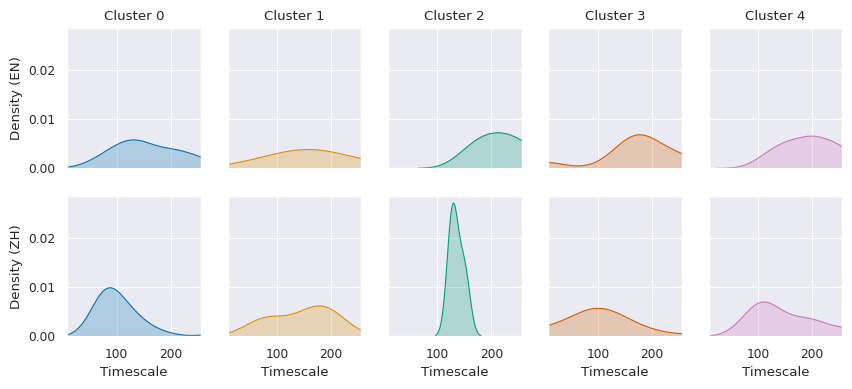

In [23]:
cmap = create_discrete_cmap(5)
# plot zn and en timescale in one plot
n_clusters = 5

fig, axs = plt.subplots(2, n_clusters, figsize=(10, 4), sharex=True, sharey=True)

plot_histogram_for_each_cluster(valid_en_timescale, valid_en_cluster, cmap, axs=axs[0,:], y_label="Density (EN)")
plot_histogram_for_each_cluster(valid_zh_timescale, valid_zh_cluster, cmap, axs=axs[1,:], y_label="Density (ZH)", title=False)

plt.show()

In [24]:
def compute_cosine_similarity(
    fasttext_pca: np.ndarray, cluster_centers: np.ndarray
):
    similarity = cosine_similarity(fasttext_pca, cluster_centers)
    return similarity

In [25]:
en_cos_sim = compute_cosine_similarity(en_fasttext_values, centroids)
zh_cos_sim = compute_cosine_similarity(zh_fasttext_values, centroids)

In [26]:
# now for each center, pick 10 words that has highest cosine similarity
n_words = 10

en_words_idx = np.argsort(en_cos_sim, axis=0)[-n_words:][::-1]
zh_words_idx = np.argsort(zh_cos_sim, axis=0)[-n_words:][::-1]

In [27]:
# print en words
for i in range(n_clusters):
    print(f"Cluster {i}")
    print(en_words[en_words_idx[:, i]])
    print()

Cluster 0
['brooklyn' 'b' 'brown' 'j' 'merrill' 'leroy' 'tartabull' 'rob' 'george'
 'six']

Cluster 1
['campus' 'moved' 'avenue' 'semester' 'parking' 'ithaca' 'boulder'
 'weekends' 'halls' 'park']

Cluster 2
['thinks' 'admit' 'wrong' 'sorry' 'know' 'why' 'believe' 'knew' 'excuse'
 'pretend']

Cluster 3
['asked' 'blurted' 'asks' 'wife' 'told' 'remarried' 'apologize' 'ask'
 'girlfriend' 'daughter']

Cluster 4
['wife' 'daughter' 'married' 'girlfriend' 'remarried' 'parents' 'mother'
 'husband' 'boyfriend' 'father']



In [28]:
# print en words
for i in range(n_clusters):
    print(f"Cluster {i}")
    print(zh_words[zh_words_idx[:, i]])
    print()

Cluster 0
['皮' '鼓' '杵' '七十' '布' '磅' '戴' '安' '马' '特']

Cluster 1
['前往' '露台' '搬到' '大厅' '门口' '街上' '来到' '大街' '客厅' '参观']

Cluster 2
['真的' '痛恨' '再婚' '知道' '抱歉' '原谅' '怀孕' '为何' '真是' '既然']

Cluster 3
['打电话' '答应' '回信' '告诉' '结婚' '妻子' '女儿' '儿子' '再婚' '回答']

Cluster 4
['妻子' '结婚' '再婚' '打电话' '女儿' '丈夫' '男友' '父母' '儿子' '母亲']



In [29]:
# num data per cluster
en_cluster_count = np.bincount(valid_en_cluster)
en_cluster_count

array([35,  9,  6, 27, 28])

In [30]:
zh_cluster_count = np.bincount(valid_zh_cluster)
zh_cluster_count

array([38,  6,  3, 27, 31])